In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# Definido as variáveis de entrada e variável de saída
# range pra todas variáveis de pertinência, cria array 0 - 100 
# obs: np.arange(início, fim+1, passo)
temperatura = ctrl.Antecedent(np.arange(0, 101, 1), 'temperatura')
fluxo_agua = ctrl.Antecedent(np.arange(0, 101, 1), 'fluxo_agua')
abertura_valvula = ctrl.Consequent(np.arange(0, 101, 1), 'abertura_valvula')

# Pertinência para temperatura - usando funções trapezoidais para melhor representação nas extremidades
# Matematicamente, φbaixa(t) = Trap(t; 0, 0, 20, 50)
temperatura['baixa'] = fuzz.trapmf(temperatura.universe, [0, 0, 20, 50])
# φmédia(t) = Trap(t; 25, 40, 60, 75)
temperatura['média'] = fuzz.trapmf(temperatura.universe, [25, 40, 60, 75])
# φalta(t) = Trap(t; 50, 80, 100, 100)
temperatura['alta'] = fuzz.trapmf(temperatura.universe, [50, 80, 100, 100])

# Pertinência para o fluxo de água
# φbaixo(f) = Trap(f; 0, 0, 20, 50)
fluxo_agua['baixo'] = fuzz.trapmf(fluxo_agua.universe, [0, 0, 20, 50])
# φmédio(f) = Trap(f; 25, 40, 60, 75)
fluxo_agua['médio'] = fuzz.trapmf(fluxo_agua.universe, [25, 40, 60, 75])
# φalto(f) = Trap(f; 50, 80, 100, 100)
fluxo_agua['alto'] = fuzz.trapmf(fluxo_agua.universe, [50, 80, 100, 100])

# Pertinência da abertura da válvula
# φpequena(v) = Trap(v; 0, 0, 20, 50)
abertura_valvula['pequena'] = fuzz.trapmf(abertura_valvula.universe, [0, 0, 20, 50])
# φmoderada(v) = Trap(v; 25, 40, 60, 75)
abertura_valvula['moderada'] = fuzz.trapmf(abertura_valvula.universe, [25, 40, 60, 75])
# φgrande(v) = Trap(v; 50, 80, 100, 100)
abertura_valvula['grande'] = fuzz.trapmf(abertura_valvula.universe, [50, 80, 100, 100])

## Descrição das Funções de Pertinência

Foram escolhidas funções trapezoidais (in code: trapmf), escolhidas por lógica, tem melhor representatividade quando temos valores extremos, mantém max. pertinência no intervalo ao invés de apenas um ponto específico.

Técnicamente, essa representação trapezoidal permite uma transição mais suave entre os conjuntos.

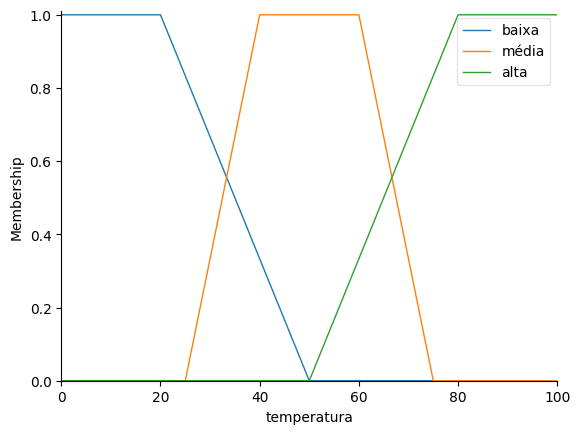

In [ ]:
temperatura.view()

In [ ]:
# Apresentamos ao fuzzy nossas JÁ CONHECIDAS regras (var: temp, h2o_flux, Valve)

# Se a água tá gelada e o fluxo tá no máximo, abre a válvula toda
# Precisamos de mais água quente pra compensar o alto fluxo
regra1 = ctrl.Rule(temperatura['baixa'] & fluxo_agua['alto'], abertura_valvula['grande'])

# Se a água tá gelada mas o fluxo não tá tão forte, abre a válvula mais ou menos
# Água fria com fluxo médio precisa de uma abertura média pra equilibrar
regra2 = ctrl.Rule(temperatura['baixa'] & fluxo_agua['médio'], abertura_valvula['moderada'])

# Se a temperatura tá ok mas tem muita água saindo, abre meio a meio
# Fluxo alto com temperatura adequada precisa de ajuste moderado
regra3 = ctrl.Rule(temperatura['média'] & fluxo_agua['alto'], abertura_valvula['moderada'])

# Se a temperatura tá boa e o fluxo tá fraco, deixa a válvula quase fechada
# Não precisa de muita água quente quando o fluxo é baixo e temp já tá ok
regra4 = ctrl.Rule(temperatura['média'] & fluxo_agua['baixo'], abertura_valvula['pequena'])

# Se a água tá quente demais e o fluxo tá baixo, abre só um pouquinho
# Água já tá quente e saindo pouco, então é melhor não abrir muito
regra5 = ctrl.Rule(temperatura['alta'] & fluxo_agua['baixo'], abertura_valvula['pequena'])

# Se tá muito quente mas tem muito fluxo, abre no meio termo
# Mesmo com água quente, o fluxo alto pode diluir, então abertura é moderada
regra6 = ctrl.Rule(temperatura['alta'] & fluxo_agua['alto'], abertura_valvula['moderada'])

# PLUS RULES - escalando algumas regras extras, além das definidas pelo professor Evandro na questão
# Água fria e pouca água saindo = precisa maximizar o aquecimento
regra7 = ctrl.Rule(temperatura['baixa'] & fluxo_agua['baixo'], abertura_valvula['grande'])

# Se tanto a temperatura quanto o fluxo tão na média, mantém no meio
# Situação equilibrada pede uma abertura equilibrada
regra8 = ctrl.Rule(temperatura['média'] & fluxo_agua['médio'], abertura_valvula['moderada'])

# Se tá muito quente e o fluxo tá mediano, deixa quase fechado
# Água quente e fluxo razoável = melhor limitar para não escaldar
regra9 = ctrl.Rule(temperatura['alta'] & fluxo_agua['médio'], abertura_valvula['pequena'])

In [ ]:
# Criamos o sistema de controle com as regras que definimos acima
sistema_controle = ctrl.ControlSystem([regra1, regra2, regra3, regra4, regra5, regra6, regra7, regra8, regra9])
simulacao = ctrl.ControlSystemSimulation(sistema_controle)

In [ ]:
# Params de entrada (temperatura & fluxo de h2o)
temp = 30
fluxo = 20

# run na simulação!
simulacao.input['temperatura'] = temp
simulacao.input['fluxo_agua'] = fluxo
simulacao.compute()

# guardar o resultado para o 3d graph na cell seguir
resultado = simulacao.output['abertura_valvula']

print(f"Temperatura = {temp} | fluxo = {fluxo}:")
print(f"Abertura da válvula = {simulacao.output['abertura_valvula']:.2f}")

Temperatura = 30 | fluxo = 20:
Abertura da válvula = 59.07



Regras ativadas para o ponto destacado com * (Temp=30, Fluxo=20):
------------------------------------------------------------
Ativação das regras:
  Regra 4: Média & Baixo → Pequena → Ativação: 0.33
  Regra 7: Baixa & Baixo → Grande → Ativação: 0.67

Regras com maior influência no resultado:
  Regra 7: Baixa & Baixo → Grande


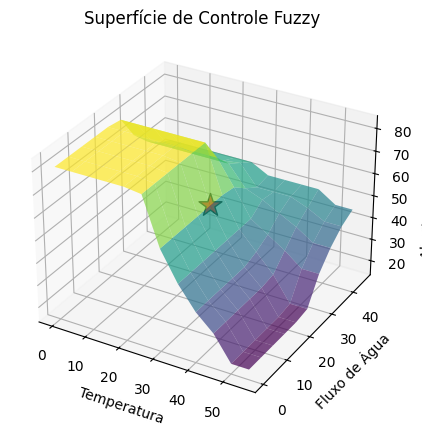

<Figure size 500x500 with 0 Axes>

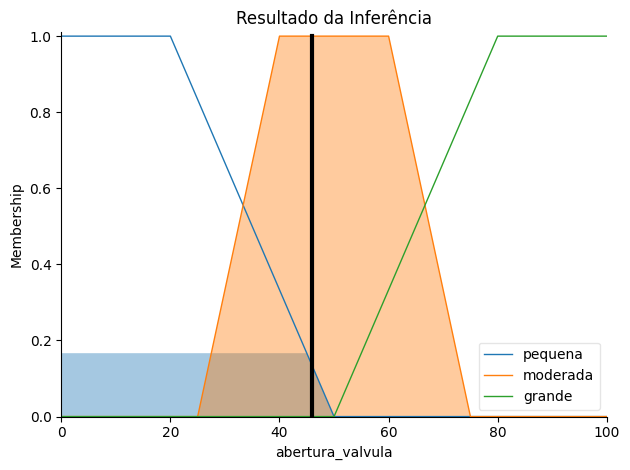

In [ ]:
# Plot 3D da superfície de controle fuzzy do problema
# Não tem muita relevância, mas aqui é pra especificar e limitar o espaço do plano 3d, a gente cria intervalo de -30 e max_value de 100 para visualização 
# das informações do gráfico e definir o range max e min da região em torno do ponto testado.
temp_range = np.arange(max(0, temp-30), min(100, temp+30), 5)
fluxo_range = np.arange(max(0, fluxo-30), min(100, fluxo+30), 5)

x, y = np.meshgrid(temp_range, fluxo_range)
z = np.zeros_like(x)

# Visualização das decisões do sistema fuzzy, baseado no sistema de regras e na ativação das funções de pertinência
# E também espaço dedicado pra gerar os demais resultadosm, grafico 3d e resultado da inferência
print(f"\nRegras ativadas para o ponto destacado com * (Temp={temp}, Fluxo={fluxo}):")
print("-" * 60)

temp_baixa = fuzz.interp_membership(temperatura.universe, temperatura['baixa'].mf, temp)
temp_media = fuzz.interp_membership(temperatura.universe, temperatura['média'].mf, temp)
temp_alta = fuzz.interp_membership(temperatura.universe, temperatura['alta'].mf, temp)

fluxo_baixo = fuzz.interp_membership(fluxo_agua.universe, fluxo_agua['baixo'].mf, fluxo)
fluxo_medio = fuzz.interp_membership(fluxo_agua.universe, fluxo_agua['médio'].mf, fluxo)
fluxo_alto = fuzz.interp_membership(fluxo_agua.universe, fluxo_agua['alto'].mf, fluxo)

regras_nomes = [
    "Baixa & Alto → Grande", 
    "Baixa & Médio → Moderada",
    "Média & Alto → Moderada",
    "Média & Baixo → Pequena",
    "Alta & Baixo → Pequena",
    "Alta & Alto → Moderada",
    "Baixa & Baixo → Grande",
    "Média & Médio → Moderada",
    "Alta & Médio → Pequena"
]

# As nossas mesmas 9 regras definidas anteriormente
ativacoes = [
    min(temp_baixa, fluxo_alto),
    min(temp_baixa, fluxo_medio),
    min(temp_media, fluxo_alto),
    min(temp_media, fluxo_baixo),
    min(temp_alta, fluxo_baixo),
    min(temp_alta, fluxo_alto),
    min(temp_baixa, fluxo_baixo),
    min(temp_media, fluxo_medio),
    min(temp_alta, fluxo_medio)
]

# Esqueminha pra visualizar a ponderação das regras
# e a ativação de cada uma delas
print("Ativação das regras:")
for i, (nome, ativacao) in enumerate(zip(regras_nomes, ativacoes), 1):
    if ativacao > 0.01:
        print(f"  Regra {i}: {nome} → Ativação: {ativacao:.2f}")
    
print("\nRegras com maior influência no resultado:")
max_ativacao = max(ativacoes)
for i, (nome, ativacao) in enumerate(zip(regras_nomes, ativacoes), 1):
    if ativacao > 0.8 * max_ativacao:
        print(f"  Regra {i}: {nome}")


for i in range(len(temp_range)):
    for j in range(len(fluxo_range)):
        simulacao.input['temperatura'] = temp_range[i]
        simulacao.input['fluxo_agua'] = fluxo_range[j]
        simulacao.compute()
        z[j, i] = simulacao.output['abertura_valvula']

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, cmap='viridis', alpha=0.7)

# Draw point
ax.scatter([temp], [fluxo], [resultado], color='red', s=300, marker='*', 
           edgecolor='black', linewidth=1, zorder=10)

ax.set_xlabel('Temperatura')
ax.set_ylabel('Fluxo de Água')
ax.set_zlabel('Abertura da Válvula')
ax.set_title('Superfície de Controle Fuzzy')
plt.tight_layout()
plt.show()

abertura_valvula.view(sim=simulacao)
plt.title('Resultado da Inferência')
plt.tight_layout()
plt.show()        